# Tutorial explaining the use of different emulators, from different archives

In [1]:
import os, sys
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# our modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator.nn_emulator import NNEmulator
from lace.emulator.gp_emulator import GPEmulator
from lace.emulator import poly_p1d

## CREATE TRAINING AND TESTING ARCHIVE (Gadget)

In [3]:
# list of emulator parameters used with Gadget sims
emu_params=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']

In [4]:
archive = gadget_archive.GadgetArchive(postproc="Pedersen21")
training_data=archive.get_training_data(emu_params=emu_params)
len(training_data)

330

In [5]:
testing_data = archive.get_testing_data(sim_label='mpg_central')
len(testing_data)

11

In [6]:
kMpc = testing_data[0]['k_Mpc']
kMpc = kMpc[(kMpc>0) & (kMpc<4)]

## NEURAL NETWORK EMULATOR  

Some of the cells in this notebooks can be quite slow, so we only run them if thorough==True

In [7]:
thorough=True

### Example 1: We can train a custom emulator... 

#### A. passing a custom archive:

In [8]:
emulator = NNEmulator(archive=archive, nepochs=1)

Selected custom emulator
Use custom archive provided by the user
Training samples in archive : 330


### or a training_set label

In [9]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23',nepochs=1)

Selected training set from Cabayol23
Selected custom emulator


#### If none or both are provided, the emulator fails. 

### Example 2: We can train a pre defined emulator... 

#### A. with a training_set label

In [10]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23', emulator_label='Cabayol23', nepochs=1)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones


#### B. with an archive

In [11]:
# currently we are passing a Pedersen21 archive and asking for Cabayol23 emulator (for emu settings)
emulator = NNEmulator(archive=archive,  emulator_label='Cabayol23', nepochs=10)

Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user
Training samples in archive : 330


### Example 3: Load a pre-trained emulator, providing the path of the saved network parameters

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


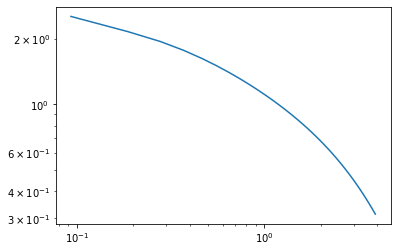

In [12]:
if thorough:
    emulator = NNEmulator(training_set='Cabayol23',emulator_label='Cabayol23',
                      model_path='NNmodels/NNEmulator_LaCEHC.pt', train=False)
    # test emulator by making simple plot
    p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
    plt.loglog(kMpc,p1d)

## GAUSSIAN PROCESS EMULATOR

## The Gaussian process emulator uses the following default parameters:

- paramList=['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'kF_Mpc']
- kmax_Mpc=10
- ndeg=4

### Example 1: Train custom emulator 

#### with a defined training_set

In [13]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21')

Selected training set from Pedersen21
Selected custom emulator


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 1.19 seconds


#### with a custom archive

In [14]:
emulator = GPEmulator(archive=archive)

Use custom archive provided by the user
Selected custom emulator
Training GP on 330 points
GPs optimised in 1.04 seconds


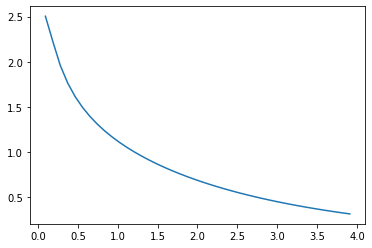

In [15]:
# test emulator by making simple plot
p1d = emulator.emulate_p1d_Mpc(testing_data[0],kMpc)
plt.plot(kMpc,p1d)

### Example 2: Pre-defined GP emulators:

In [16]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen21')

Selected training set from Pedersen21
Select emulator in Pedersen21
Gaussian Process emulator predicting the P1D at each k-bin. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones.


 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 2.12 seconds


In [17]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21', emulator_label='Pedersen23')

Selected training set from Pedersen21
Select emulator in Pedersen23
Gaussian Process emulator predicting the P1D, fitting coefficients to a 4th degree polynomial. It goes to scales of 3Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Training GP on 330 points
GPs optimised in 0.79 seconds


In [18]:
if thorough:
    emulator = GPEmulator(training_set='Pedersen21')

Selected training set from Pedersen21
Selected custom emulator
Training GP on 330 points
GPs optimised in 1.00 seconds


## LaCE-Nyx emulator (NN)

In [19]:
# emulators will use different emulator parameters depending on the archive
nyx_emu_params = ['Delta2_p', 'n_p','mF', 'sigT_Mpc', 'gamma', 'lambda_P']

In [20]:
# you could specify here the path to the Nyx files, or set a NYX_PATH variable
archive = nyx_archive.NyxArchive(file_name=None,verbose=True)

read Nyx sim bar_ic_grid_3
read Nyx sim cosmo_grid_0
read Nyx sim cosmo_grid_1
read Nyx sim cosmo_grid_10
read Nyx sim cosmo_grid_11
read Nyx sim cosmo_grid_12
read Nyx sim cosmo_grid_13
read Nyx sim cosmo_grid_2
read Nyx sim cosmo_grid_3
read Nyx sim cosmo_grid_4
read Nyx sim cosmo_grid_5
read Nyx sim cosmo_grid_6
read Nyx sim cosmo_grid_7
read Nyx sim cosmo_grid_8
read Nyx sim cosmo_grid_9
read Nyx sim fiducial
read Nyx sim wdm_3.5kev_grid_1


In [21]:
emulator = NNEmulator(archive=archive, drop_sim = 'nyx_3', emu_params=nyx_emu_params)

Selected custom emulator
Use custom archive provided by the user
Training samples in archive : 3985


Selected training set from Nyx23
Select emulator in Cabayol23_Nyx
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


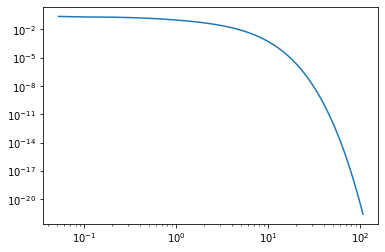

In [22]:
if thorough:
    emulator = NNEmulator(training_set='Nyx23',emulator_label='Cabayol23_Nyx',
                            emu_params=nyx_emu_params,
                            model_path='NNmodels/NNEmulator_Nyx.pt', train=False)
    # test emulator by making simple plot
    testing_data=emulator.archive.get_testing_data('nyx_3')
    k_Mpc=testing_data[0]['k_Mpc']
    model=testing_data[0]
    p1d = emulator.emulate_p1d_Mpc(model,k_Mpc)
    plt.loglog(k_Mpc,p1d)

In [23]:
if thorough:
    emulator = NNEmulator(archive=archive, drop_sim = 'nyx_3', emulator_label='Cabayol23_Nyx', emu_params=nyx_emu_params)

Select emulator in Cabayol23_Nyx
Neural network emulating the optimal P1D of Nyx simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Use custom archive provided by the user
Training samples in archive : 3985


In [24]:
# test emulator by making simple plot
testing_data = archive.get_testing_data(sim_label='nyx_3',emu_params=nyx_emu_params)

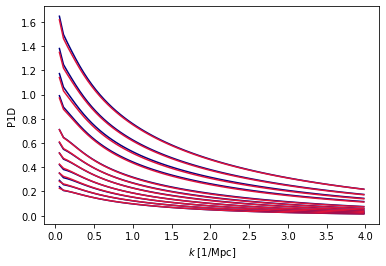

In [25]:
p1ds_true = np.zeros(shape=(11,76))
p1ds = np.zeros(shape=(11,76))

for m in range(11):
    p1d_true = testing_data[m]['p1d_Mpc']
    kMpc = testing_data[m]['k_Mpc']
    kMpc_test = kMpc[(kMpc>0) & (kMpc<4)]
    p1d_true = p1d_true[(kMpc>0) & (kMpc<4)]
    
    fit_p1d = poly_p1d.PolyP1D(kMpc_test,p1d_true, kmin_Mpc=1.e-3,kmax_Mpc=4,deg=5)
    p1d_true = fit_p1d.P_Mpc(kMpc_test)
    
    p1d = emulator.emulate_p1d_Mpc(testing_data[m],kMpc_test)
    
    
    p1ds_true[m] = p1d_true
    p1ds[m] = p1d
    
    plt.plot(kMpc_test,p1d, label = 'Emulated', color = 'navy')
    plt.plot(kMpc_test,p1d_true, label = 'True', color = 'crimson')

    plt.xlabel(r'$k$ [1/Mpc]')
    plt.ylabel(r'P1D')

plt.show()

In [26]:
percent_error = (p1ds / p1ds_true -1)*100

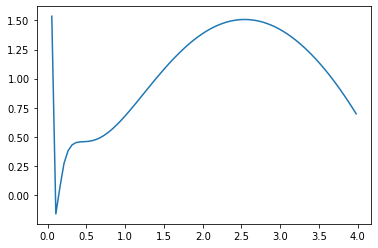

In [27]:
plt.plot(kMpc_test,percent_error.mean(0))

In [28]:
if thorough:
    emulator = NNEmulator(training_set='Nyx23',emu_params=nyx_emu_params,nepochs=1)

Selected training set from Nyx23
Selected custom emulator
